iteration: 31


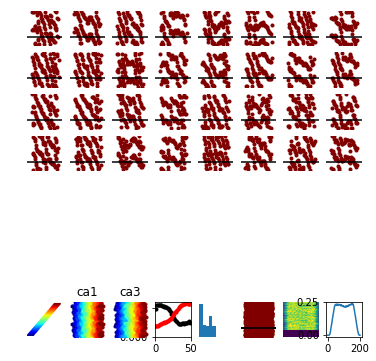

iteration: 32


In [ ]:
# this is a simulation of CA1/CA3 'place field' populations that project onto a single LS neuron. 
# david tingley 2018

%matplotlib inline 
from pyNN.neuron import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.signal as sig   
from scipy.stats.mstats import zscore
from IPython import display
import time

def get_cmap(n, name='jet'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def getRate(spkCount,ls_voltages):
    spk = (ls_voltages.segments[-1].spiketrains[0])
    h = np.histogram(spk,200,range=(0,runtime))
    spkCount = spkCount + h[0]
    box = np.append(np.zeros((85,1)),np.append(sig.boxcar(30)/30, np.zeros((85,1))))
    spkCount = np.convolve(spkCount[0,:], box, mode='same')
    return spkCount

def plot_spiketrains(segment,offset):
    c=get_cmap(len(segment.spiketrains))
    for spiketrain in segment.spiketrains:
        spk_id = spiketrain.annotations['source_index']
        y = np.ones_like(spiketrain) * spk_id
        plt.plot(spiketrain, y+offset, '.',color=c(spk_id))
        # plt.ylabel(segment.name)
        plt.setp(plt.gca().get_xticklabels(), visible=True)

def plot_phaseclouds(segment,phaseJitters):
    c=get_cmap(len(segment.spiketrains))
    for spiketrain in segment.spiketrains:
        spk_id = spiketrain.annotations['source_index']
        # if spk_id == 10 or spk_id == 50: # comment to plot single cell across trials
        for spk in np.arange(0,len(spiketrain),1):
            plt.plot(spiketrain[spk],phaseJitters[int(round(100*spiketrain[spk]))],'.',color=c(spk_id))
        # plt.ylabel(segment.name)
        plt.setp(plt.gca().get_xticklabels(), visible=True)

cellparams = {
        'gbar_Na'   : 20.0,
        'gbar_K'    : 6.0,
        'g_leak'    : 0.01,
        'cm'        : 0.2,
        'v_offset'  : -63.0,
        'e_rev_Na'  : 50.0,
        'e_rev_K'   : -90.0,
        'e_rev_leak': -65.0,
        'e_rev_E'   : -6.0,  #
        'e_rev_I'   : -71.0, #
        'tau_syn_E' : 1.0,
        'tau_syn_I' : 2.0,
        'i_offset'  : 0.0,
    }

plt.ion()
fig = plt.figure(figsize=(6,6))

# free parameters
numcells = 50
thetaFreq = 8
interval = 100 # we want fields to span/tile the 'space', assuming a constant running velocity
offsets = 2 # number of theta offsets. this mimics the transverse axis, CA1-CA3. 
lsInputThresh = .0001 * interval / offsets  # controls net excitation per unit time
runtime = 6500
numIterations = 40
# also see 'fieldInput' and 'thetaInput' below..

# initialize and load data
spkCount = np.zeros((200,numIterations))
data = sio.loadmat('assemblyWeights.mat')
ca1Weights = data['ca1'] 
ca3Weights = data['ca3'] 
ca1Weights = np.interp(np.linspace(0,200,numcells),np.linspace(0,200,200),ca1Weights[:,0]) # interp to # of cells
ca3Weights = np.interp(np.linspace(0,200,numcells),np.linspace(0,200,200),ca3Weights[:,0]) #


for iteration in range(0,numIterations,1):
    print('iteration: ' + str(iteration))
    for fieldInput in [.033]: #np.arange(.03,.045,.005): # field input (arange is the range of values tested)
        for thetaInput in [.01]: #np.arange(.008,.015,.003): # theta input (arange is the range of values tested)
            setup(timestep=0.01, min_delay=1.0)
            # phaseJitter = np.random.uniform(0,360) # make sure the position/theta phase relationship is random across trials
            fieldJitter = np.random.uniform(0,250) # add a little noise to individual fields (not necessary, just more realistic)
            
            if iteration == 0: # set up the populations and connection weights on first trial
                standard_model = StaticSynapse(weight=0,delay=7.0);
                LS = Population(1, HH_cond_exp(**cellparams), label='LS')
                CA123 = []
                CA123_connections = []
                for p in range(0,offsets,1):
                    CA123.append(Population(numcells, HH_cond_exp, {'e_rev_I': -75}, label='HPC'))
                    CA123_connections.append(Projection(CA123[p],LS,AllToAllConnector(allow_self_connections=False),standard_model))
                    CA123[p].record('spikes')
                for p in range(0,offsets,1):
                    if p == 0:
                        newWeights = ca1Weights 
                    else:
                        newWeights = ca3Weights 
                    CA123_connections[p].setWeights(newWeights)

            # trial specific stuff to set up
            ## this is where we diverge from the original model, injecting different (phase offset) theta oscillations into each cell
            # note we preserve the 180 phase offset b/w CA1 and CA3
            synTheta_rand = []
            synTheta_rand_ca3 = []
            for p in range(0,numcells,1):
                phaseJitter = np.random.uniform(0,360)
                synTheta_rand.append(ACSource(start=0, stop=runtime, amplitude=thetaInput, offset=thetaInput,
                                    frequency=thetaFreq, phase=phaseJitter))
                synTheta_rand_ca3.append(ACSource(start=0, stop=runtime, amplitude=thetaInput, offset=thetaInput,
                                    frequency=thetaFreq, phase=phaseJitter + 180))
            # synTheta = []
            # for p in range(0,offsets,1):
            #     synTheta.append(ACSource(start=0, stop=runtime, amplitude=thetaInput, offset=thetaInput,
            #                         frequency=thetaFreq, phase=phaseJitter + np.linspace(0,180,offsets)[p]))

            for p in range(0,offsets,1):
                count = 0
                for cell in CA123[p]:
                    if p == 0:
                        cell.inject(synTheta_rand[count])
                    else:
                        cell.inject(synTheta_rand_ca3[count])
                    count = count +1;
                # CA123[p].inject(synTheta[p])
            ##

            # let's make some place/time fields...
            for i in range(0, numcells, 1):
                fieldStart = int(i*interval+fieldJitter+np.random.uniform(-15,15)) # add some jitter across both trials and cells..
                fieldStop = int(fieldStart+1000)
                fieldStop = int(fieldStart+len(np.arange(0, fieldInput,(fieldInput)/(fieldStop-fieldStart))))
                synfieldInput = StepCurrentSource(times=np.arange(fieldStart, fieldStop+1,1),amplitudes=np.append(np.arange(0, fieldInput,(fieldInput)/(fieldStop-fieldStart)),0))
                for p in range(0,offsets,1):
                    CA123[p][i].inject(synfieldInput)
                if iteration == 0:
                    plt.subplot(8, 8, 57)
                    c=get_cmap(numcells)
                    plt.plot(synfieldInput.times,synfieldInput.amplitudes+i,color=c(i))
                    plt.xlim((0, runtime))
                    plt.axis('off')

            LS.record('spikes')
            LS.record('v')
            # run one trial
            run(runtime)

            # collect those data
            CA123_voltages=[]
            for p in range(0,offsets,1):
                CA123_voltages.append(CA123[p].get_data())
            ls_voltages = LS.get_data()
  
            # plot some stuffs
            if np.mod(iteration,1) == 0 or iteration == 0:
                plt.subplot(8,8,60)
                plt.cla()
                plt.plot(CA123_connections[0].getWeights(),'k.') # ca1
                plt.plot(CA123_connections[-1].getWeights(),'r.') # ca3
                plt.xlim((0,numcells))
                plt.ylim((0,.006))
                plt.subplot(8,8,61)
                plt.cla()
                plt.hist(CA123_connections[p].getWeights(),range=(np.min(CA123_connections[p].getWeights()), 2*np.max(CA123_connections[p].getWeights())))
                plt.axis('off')
                plt.subplot(8,8, round(iteration / 1)+1)
                plot_phaseclouds(ls_voltages.segments[-1],np.angle(sig.hilbert(zscore(synTheta_rand[0].amplitudes))))
                plot_phaseclouds(ls_voltages.segments[-1],np.angle(sig.hilbert(zscore(synTheta_rand[0].amplitudes)))+6.29)
                plt.plot([0,runtime],[0,0],'k')
                plt.xlim((0, runtime))
                plt.ylim((-3.14, 3.14*3))
                plt.axis('off')
                plt.subplot(8,8, 62)
                plot_phaseclouds(ls_voltages.segments[-1],np.angle(sig.hilbert(zscore(synTheta_rand[0].amplitudes))))
                plot_phaseclouds(ls_voltages.segments[-1],np.angle(sig.hilbert(zscore(synTheta_rand[0].amplitudes)))+6.29)
                plt.plot([0,runtime],[0,0],'k')
                plt.xlim((0, runtime))
                plt.ylim((-3.14, 3.14*3))
                plt.axis('off')
                plt.subplot(8,8,63)
                plt.cla()
                spkCount[:,iteration] = getRate(np.zeros((1,200)),ls_voltages)
                plt.imshow(np.transpose(spkCount[20:180,:]),aspect='auto')
                plt.axis('off')
                plt.subplot(8,8,64)
                plt.cla()
                plt.plot(np.mean(spkCount,1))
            if iteration == 0:
                plt.subplot(8,8, 58)
                plot_phaseclouds(CA123_voltages[0].segments[-1],np.angle(sig.hilbert(zscore(synTheta_rand[0].amplitudes))))
                plot_phaseclouds(CA123_voltages[0].segments[-1],np.angle(sig.hilbert(zscore(synTheta_rand[0].amplitudes)))+6.29)
                plt.xlim((0, runtime))
                plt.ylim((-3.14, 3.14*3))
                plt.axis('off')
                plt.title('ca1')
                plt.subplot(8,8, 59)
                plot_phaseclouds(CA123_voltages[1].segments[-1],np.angle(sig.hilbert(zscore(synTheta_rand[0].amplitudes))))
                plot_phaseclouds(CA123_voltages[1].segments[-1],np.angle(sig.hilbert(zscore(synTheta_rand[0].amplitudes)))+6.29)
                plt.title('ca3')
                plt.xlim((0, runtime))
                plt.ylim((-3.14, 3.14*3))
                plt.axis('off')
    display.clear_output(wait=True)
    print('iteration: ' + str(iteration))
    display.display(plt.gcf())
    plt.pause(.1)

    # uncomment below if you would like to save data
    # CA123[0].write_data(io)
    # CA123[1].write_data(io)
    # io = NeoMatlabIO(filename='data/dynamic_ls_output_' + str(iteration) + '.mat')
    # LS.write_data(io)
    # sio.savemat('data/dynamic_trial_' + str(iteration) + '_theta.mat',mdict={'theta': synTheta[0].amplitudes})
    # reset sim
    reset(annotations={"iteration" : iteration})
